# **Breast Cancer - Grad-CAM Project**

Dataset link: https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/

In this project will be used: 
* Magnification factor is 400x.
* CNN: EfficientNetB0

In [1]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image
import matplotlib.cm as cm

import tensorflow as tf
import keras
from tensorflow.keras import mixed_precision, layers, Sequential
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow.io as tfio
import cv2 as cv

import warnings
warnings.filterwarnings("ignore")

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
#Walk through directories
for dirpath, dirnames, filenames in os.walk("SiDi_BreakHis400x_Balanceado/train_set/"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
print('\n')
for dirpath, dirnames, filenames in os.walk("SiDi_BreakHis400x_Balanceado/validation_set/"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'SiDi_BreakHis400x_Balanceado/train_set/'.
There are 0 directories and 1037 images in 'SiDi_BreakHis400x_Balanceado/train_set/benign'.
There are 0 directories and 1037 images in 'SiDi_BreakHis400x_Balanceado/train_set/malignant'.


There are 2 directories and 0 images in 'SiDi_BreakHis400x_Balanceado/validation_set/'.
There are 0 directories and 180 images in 'SiDi_BreakHis400x_Balanceado/validation_set/benign'.
There are 0 directories and 180 images in 'SiDi_BreakHis400x_Balanceado/validation_set/malignant'.


In [4]:
# loading directories
train_dir = 'SiDi_BreakHis400x_Balanceado/train_set/'
val_dir = 'SiDi_BreakHis400x_Balanceado/validation_set/'
test_dir = 'BreCaHAD_test_png/'
annotated_dir = 'groundTruth_display/'

In [5]:
# loading data
IMG_SIZE=(224,224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir, image_size=IMG_SIZE, 
                                                                 label_mode="categorical")
val_data = tf.keras.preprocessing.image_dataset_from_directory(directory=val_dir, image_size=IMG_SIZE, 
                                                               label_mode="categorical")
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir, image_size=IMG_SIZE, 
                                                                label_mode=None)

Found 2074 files belonging to 2 classes.
Found 360 files belonging to 2 classes.
Found 162 files belonging to 1 classes.


In [6]:
class_names = train_data.class_names
class_names

['benign', 'malignant']

In [7]:
# Function to see random image
def view_random_image(target_dir):
    
    # Get a random image path
    random_image = random.sample(os.listdir(target_dir), 1)
    
    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_dir + random_image[0])
    plt.imshow(img)
    plt.title(f'{target_dir.split("/")[1]}\n{img.shape}')
    plt.axis('off');
    
    return img

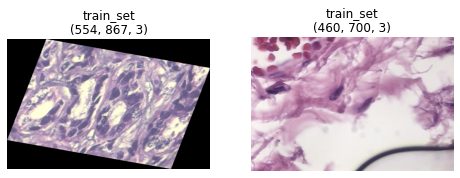

In [8]:
# view random image from training dataset
plt.figure(figsize=(8,6))

plt.subplot(1,2,1)
img1 = view_random_image('SiDi_BreakHis400x_Balanceado/train_set/benign/')

plt.subplot(1,2,2)
img2 = view_random_image('SiDi_BreakHis400x_Balanceado/train_set/malignant/')

## Creating Modelling Callbacks 

In [9]:
# Setup Earlystopping callback to stop training if model's val_loss doesn't improve for 5 epochs
ea = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

## Setting Mixed Precision

In [10]:
# turn on mixed precision training
mixed_precision.set_global_policy('mixed_float16') # set global data policy to mixed precision

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650, compute capability 7.5


In [19]:
# # Create data augmentation to incorporate it right into the model
# data_augmentation = Sequential([
#     preprocessing.RandomFlip(),
# #     preprocessing.RandomZoom(0.2),
#     preprocessing.RandomWidth(0.2),
#     preprocessing.RandomHeight(0.2),
# #     preprocessing.RandomRotation(20),
# #     preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
# #     preprocessing.Rescaling(1/255.)
# ], name='data_augmentation')

## Building Feature Extraction Model 

In [76]:
# Create base model
input_shape = (224,224,3)

# Create Functional Model
inputs = layers.Input(shape=input_shape, name='input_layer')
base_model = tf.keras.applications.EfficientNetB0(include_top=False, input_tensor=inputs)
base_model.trainable = False
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(2, activation='softmax', dtype=tf.float32, name='softmax_float32')(x)
model = tf.keras.Model(inputs, outputs, name='efficientB0_model')

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [77]:
# model summary
model.summary()

Model: "efficientB0_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_layer[0][0]']            
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                  

In [78]:
# Fitting the model
warnings.filterwarnings('ignore')

history_base = model.fit(train_data, epochs=5, steps_per_epoch=len(train_data), validation_data=val_data,
                        validation_steps=len(val_data), callbacks=[reduce_lr])

Epoch 1/5
65/65 [==============================] - 24s 264ms/step - loss: 0.3260 - accuracy: 0.8568 - val_loss: 0.5018 - val_accuracy: 0.7639 - lr: 0.0010
Epoch 2/5
65/65 [==============================] - 16s 231ms/step - loss: 0.2162 - accuracy: 0.9127 - val_loss: 0.4999 - val_accuracy: 0.7667 - lr: 0.0010
Epoch 3/5
65/65 [==============================] - 15s 227ms/step - loss: 0.1807 - accuracy: 0.9286 - val_loss: 0.3735 - val_accuracy: 0.8417 - lr: 0.0010
Epoch 4/5
65/65 [==============================] - 15s 227ms/step - loss: 0.1503 - accuracy: 0.9460 - val_loss: 0.3039 - val_accuracy: 0.8861 - lr: 0.0010
Epoch 5/5
65/65 [==============================] - 15s 222ms/step - loss: 0.1356 - accuracy: 0.9455 - val_loss: 0.3348 - val_accuracy: 0.8611 - lr: 0.0010


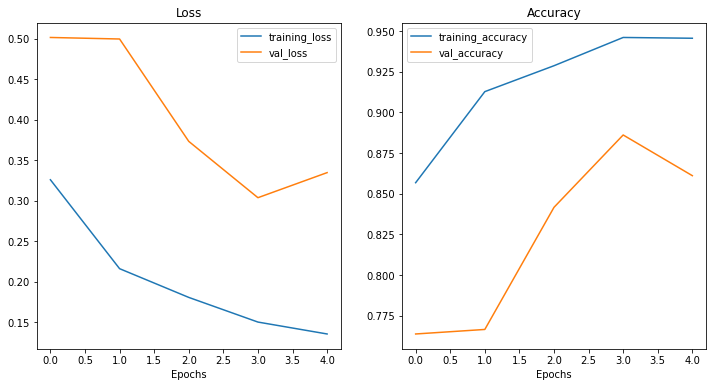

In [79]:
from helper_functions import plot_loss_curves
plot_loss_curves(history_base)

In [117]:
model.evaluate(val_data)

12/12 [==============================] - 2s 162ms/step - loss: 0.3237 - accuracy: 0.8778


[0.323718398809433, 0.8777777552604675]

## Fine-Tuning the Model 

In [16]:
# To begin fine-tuning, let's start setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze again all layers except the last 20
for layer in base_model.layers[:-20]:
    layer.trainable = False

In [17]:
# recompile the model lowering the learning rate
model.compile(loss='binary_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [18]:
model.summary()

Model: "base_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetv2-l (Functiona  (None, None, None, 1280)  117746848
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 binary_float32 (Dense)      (None, 2)                 2562      
                                                        

In [19]:
# Training again
## fine tune for another 5 epochs
init_epochs = 10
ft_epochs = init_epochs + 5

# refitting the model
history_ft = model.fit(train_data, epochs=ft_epochs, steps_per_epoch=len(train_data), validation_data=val_data,
                      initial_epoch=init_epochs, validation_steps=len(val_data), callbacks=[ea, reduce_lr])

Epoch 11/15
50/50 [==============================] - 212s 3s/step - loss: 0.7204 - accuracy: 0.7262 - val_loss: 0.3232 - val_accuracy: 0.8546 - lr: 0.0010
Epoch 12/15
50/50 [==============================] - 159s 3s/step - loss: 0.4076 - accuracy: 0.8095 - val_loss: 0.2668 - val_accuracy: 0.8872 - lr: 0.0010
Epoch 13/15
50/50 [==============================] - 159s 3s/step - loss: 0.3170 - accuracy: 0.8703 - val_loss: 0.2376 - val_accuracy: 0.9073 - lr: 0.0010
Epoch 14/15
50/50 [==============================] - 159s 3s/step - loss: 0.2944 - accuracy: 0.8659 - val_loss: 0.2366 - val_accuracy: 0.9248 - lr: 0.0010
Epoch 15/15
50/50 [==============================] - 154s 3s/step - loss: 0.2686 - accuracy: 0.8897 - val_loss: 0.2166 - val_accuracy: 0.9123 - lr: 0.0010


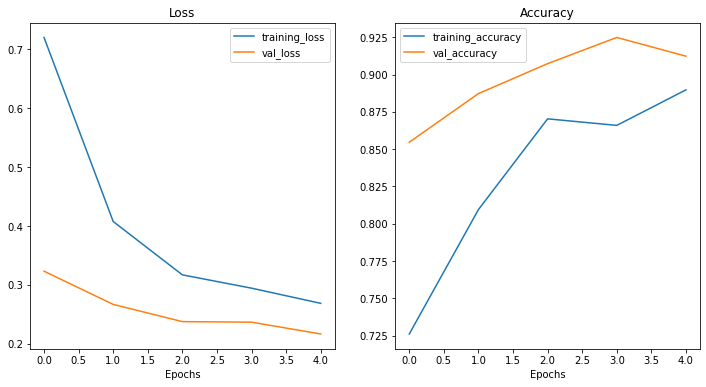

In [20]:
plot_loss_curves(history_ft)

## Saving Model 

In [80]:
model.save('models/model', save_format='h5')

In [11]:
test_model = tf.keras.models.load_model('models/model')

## Implementing Grad-CAM to the model

Grad-Cam, unlike CAM, uses the gradient information flowing into the last convolutional layer of the CNN to understand each neuron for a decision of interest. 

In [81]:
model.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_layer')>

In [12]:
last_conv_layer_name = list(filter(lambda x: isinstance(x, keras.layers.Conv2D), base_model.layers))[-1].name
print(last_conv_layer_name) 

top_conv


In [28]:
def get_img_array(img_path, size):

    # `img` is a PIL image of size 299x299
    img = tf.keras.utils.load_img(img_path, target_size=size)
    
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.utils.img_to_array(img)
    
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model([model.inputs], 
                                       [base_model.get_layer(last_conv_layer_name).output, model.output])
           

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, predictions = grad_model(img_array)
        predictions = tf.squeeze(predictions)
        if pred_index is None:
            pred_index = tf.argmax(predictions)
        class_channel = predictions[pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

In [33]:
# Prepare image
def generate_heatmap(img_path):
    img_array = get_img_array(img_path, size=(224,224))

    # Remove last layer's softmax
#     test_model.layers[-1].activation = None

    # Print what the top predicted class is
    preds = model.predict(img_array)
    model_preds = tf.squeeze(tf.round(preds))
    top_pred_index = tf.argmax(preds[0])

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    heat_test = heatmap.copy()

    # Display heatmap
#     plt.matshow(heatmap)
#     plt.show()
    
    return heatmap, class_names[top_pred_index], preds[0][top_pred_index]

In [31]:
def save_and_display_gradcam(img_path, heatmap, cam_path="saved/teste_1.jpg", alpha=0.5, pred=None):
    # Load the original image
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    if pred == 'malignant':
        jet = cm.get_cmap("Set1")
    else:
        jet = cm.get_cmap("Set2")

    # Use RGB values of the colormap
#     jet_colors = jet(np.arange(256))[:, :3]
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap) #keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = np.array(jet_heatmap) # keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)
    
    # generating mask
    ret, thresh = cv.threshold(jet_heatmap, 180, 255, cv.THRESH_BINARY)
    thresh = cv.cvtColor(thresh, cv.COLOR_BGR2GRAY)

    # Display Grad CAM
    plt.imshow(superimposed_img)
    
    return thresh

In [32]:
plt.figure(figsize=(20,16))

PATH1 = 'groundTruth_display/Case_4-01.png'
IMG1 = 'BreCaHAD_test_png/Case_4-01.png'
img1 = tf.keras.utils.load_img(PATH1)
img_orig = tf.keras.utils.load_img(IMG1)
heatmap1, class_1, probs1 = generate_heatmap(IMG1)

PATH2 = 'groundTruth_display/Case_7-12.png'
IMG2 = 'BreCaHAD_test_png/Case_7-12.png'
img2 = tf.keras.utils.load_img(PATH2)
img_orig_2 = tf.keras.utils.load_img(IMG2)
heatmap2, class_2, probs2 = generate_heatmap(IMG2)


plt.subplot(1,2,1)
plt.title(f'Predicted: {class_1}. Prob.: {round(probs1*100,2)}%')
plt.axis(False)
save_and_display_gradcam(img_path=IMG1, heatmap=heatmap1, cam_path='Saved/case_7_12.jpg', pred=class_1)
plt.subplot(1,2,2)
plt.title('Case 7_12')
plt.axis(False)
plt.imshow(img1)

plt.subplot(2,2,3)
plt.title(f'Predicted: {class_2}. Prob.: {round(probs2*100,2)}%')
plt.axis(False)
save_and_display_gradcam(img_path=IMG2, heatmap=heatmap2, cam_path='Saved/case_12_10.jpg', pred=class_2)
plt.subplot(2,2,4)
plt.title('Case 12_10')
plt.axis(False)
plt.imshow(img2);

NameError: name 'model' is not defined

<Figure size 1440x1152 with 0 Axes>

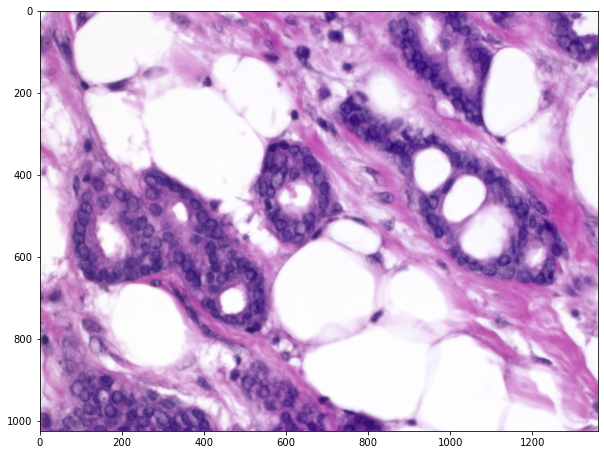

In [96]:
plt.figure(figsize=(10,10))
result = save_and_display_gradcam(img_path=IMG1, heatmap=heatmap1, cam_path='Saved/case_7_12.jpg', pred=class_1);

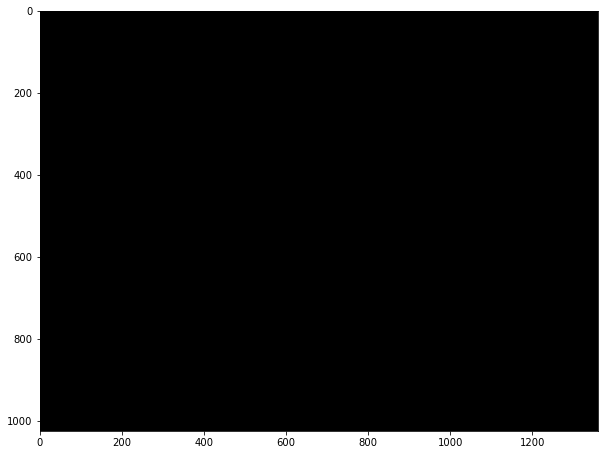

In [97]:
plt.figure(figsize=(10,10))
plt.imshow(result, cmap='gray')

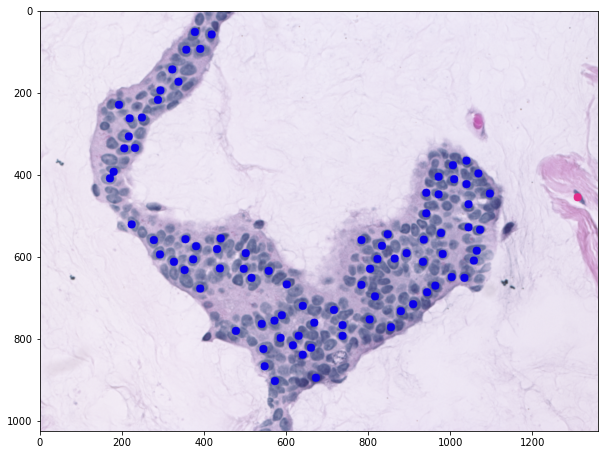

In [406]:
plt.figure(figsize=(10,10))
plt.imshow(img1)

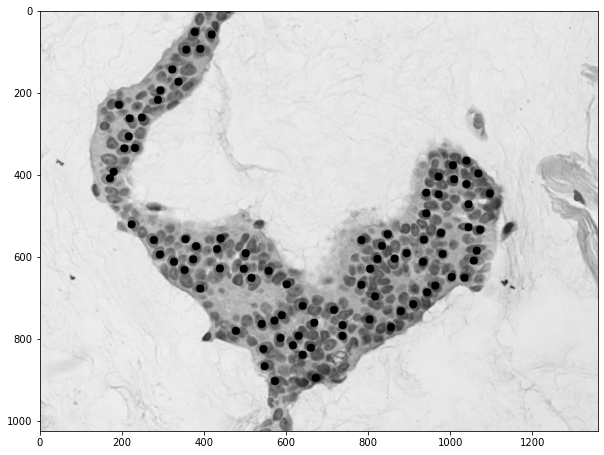

In [407]:
plt.figure(figsize=(10,10))
edited = img = tf.keras.utils.load_img(PATH1, grayscale=True)
edited = tf.keras.utils.img_to_array(edited)

plt.imshow(edited, cmap='gray')

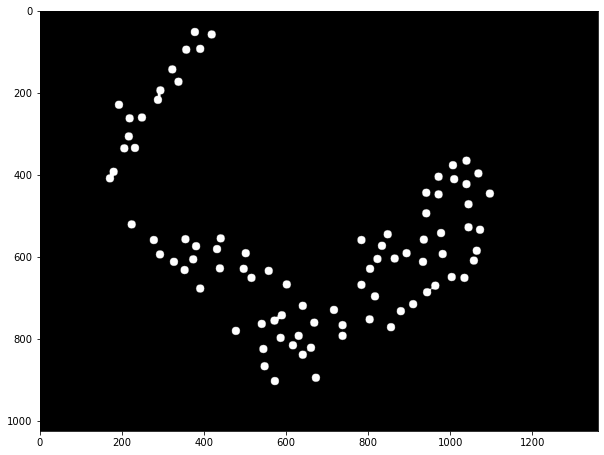

In [408]:
plt.figure(figsize=(10,10))
mask = cv.threshold(edited,40,255,cv.THRESH_BINARY_INV)[1]
mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel)
mask = np.uint8(mask)
plt.imshow(mask, cmap='gray')

(1, 88, 3)


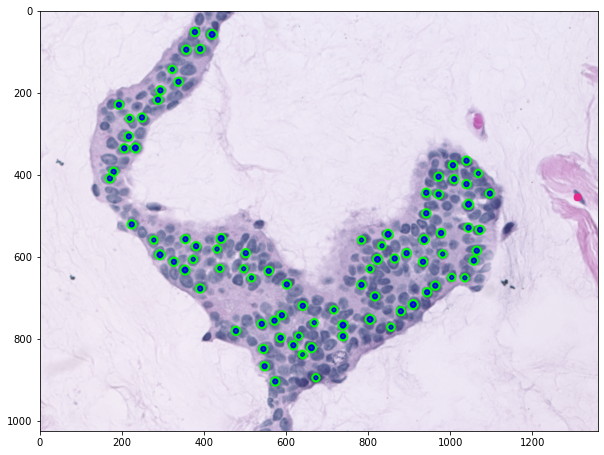

In [410]:
plt.figure(figsize=(10,10))

copia = cv.imread(PATH1)
copia = cv.cvtColor(copia, cv.COLOR_BGR2RGB)

##########
p_edges = cv.Canny(mask, 0, 255)

##########
rows = p_edges.shape[0]
circles = cv.HoughCircles(mask, cv.HOUGH_GRADIENT, dp=1.1, minDist=1, param1=250, param2=15,
                          minRadius=2, maxRadius=12)
print(circles.shape)

if circles is not None:
    # mudando o tipo de dado para int
    circles = np.uint16(np.around(circles))
    for circ in circles[0, :]:
        center = (circ[0], circ[1])

        # centro do círculo
        cv.circle(copia, center, 1, (0, 100, 100), 3)

        # círculo externo
        radius = circ[2]
        cv.circle(copia, center, radius, (0, 255, 0), 4)

plt.imshow(copia)

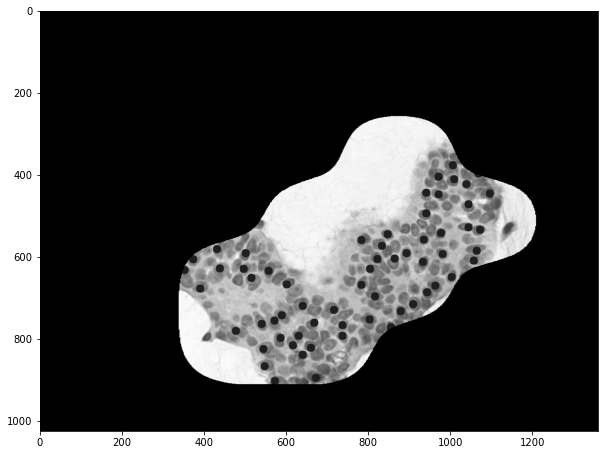

In [434]:
# inverting result mask
plt.figure(figsize=(10,10))
data1 = cv.imread(PATH1)
data1 = cv.cvtColor(data1, cv.COLOR_BGR2RGB)
final = cv.bitwise_and(data1, data1, mask = result)
final = cv.cvtColor(final, cv.COLOR_RGB2GRAY)
plt.imshow(final, cmap='gray')

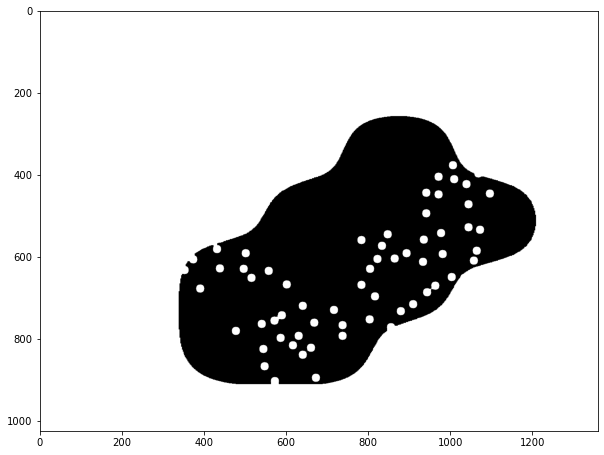

In [437]:
plt.figure(figsize=(10,10))
mask2 = cv.threshold(final,40,255,cv.THRESH_BINARY_INV)[1]
mask2 = cv.morphologyEx(mask2, cv.MORPH_CLOSE, kernel)
mask2 = np.uint8(mask2)
plt.imshow(mask2, cmap='gray')

(1, 59, 3)


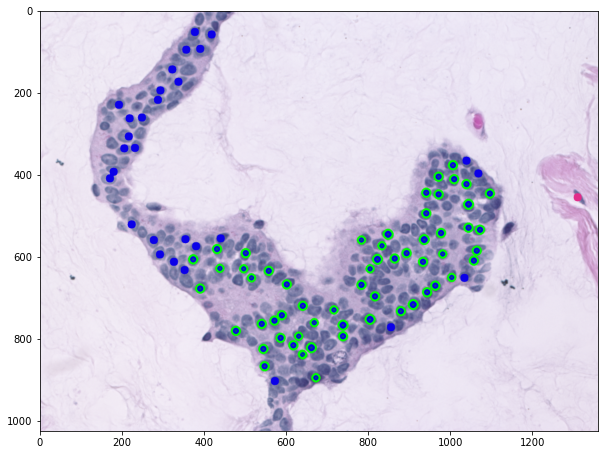

In [438]:
plt.figure(figsize=(10,10))

data2 = data1.copy()

##########
p_edges = cv.Canny(mask2, 0, 255)

##########
rows = p_edges.shape[0]
circles = cv.HoughCircles(mask2, cv.HOUGH_GRADIENT, dp=1.1, minDist=1, param1=250, param2=15,
                          minRadius=2, maxRadius=12)
print(circles.shape)

if circles is not None:
    # mudando o tipo de dado para int
    circles = np.uint16(np.around(circles))
    for circ in circles[0, :]:
        center = (circ[0], circ[1])

        # centro do círculo
        cv.circle(data2, center, 1, (0, 100, 100), 3)

        # círculo externo
        radius = circ[2]
        cv.circle(data2, center, radius, (0, 255, 0), 4)

plt.imshow(data2)

In [8]:
arquivo1 = {
    'algoritmo':1,
    'nome': 2,
    'classificação': 3,
    'probabilidade': 4,
    'qtd anotações': 5,
    'qtd acertos': 6,
    'percentual de acertos': 7
}

arquivo2 = {
    'algoritmo':1,
    'nome': 2,
    'classificação': 3,
    'probabilidade': 4,
    'qtd anotações': 5,
    'qtd acertos': 6,
    'percentual de acertos': 7
}

arquivo3 = {
    'algoritmo':1,
    'nome': 2,
    'classificação': 3,
    'probabilidade': 4,
    'qtd anotações': 5,
    'qtd acertos': 6,
    'percentual de acertos': 7
}

In [9]:
dataframe = pd.DataFrame([arquivo1, arquivo2, arquivo3])
dataframe

,algoritmo,nome,classificação,probabilidade,qtd anotações,qtd acertos,percentual de acertos
0,1,2,3,4,5,6,7
1,1,2,3,4,5,6,7
2,1,2,3,4,5,6,7


# o quanto ele acertou

# do que ele acertou, quão preciso ele foi